In [3]:
import torch

from models import checkpoint_weights
from prune_fns import prune_model

In [29]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/Citeseer', name='Citeseer')

Processing...
Done!


In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_units, hidden_units, output_units, device):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_units, hidden_units, improved=True)
        self.conv2 = GCNConv(hidden_units, output_units, improved=True)
        
        self.dropout = nn.Dropout()
        self.device = device
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = self.dropout(F.relu(x))
        return self.conv2(x, edge_index)
        
class GCN_CEL_crit(nn.Module):
    def __init__(self, data_train_mask):
        super(GCN_CEL_crit, self).__init__()
        self.train_mask = data_train_mask
        self.cel = nn.CrossEntropyLoss()
        
    def forward(self, y_pred, y_true):
        if self.training:
            return self.cel(y_pred[self.train_mask], y_true[self.train_mask])
        return self.cel(y_pred, y_true)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 32, dataset.num_classes, device).to(device)
data = dataset[0].to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

crit = GCN_CEL_crit(data.train_mask)

In [26]:
def GCN_params_fn(model):
    return [(model.conv1, "weight"),]

In [32]:
checkpoint_weights(model, GCN_params_fn)

In [31]:
count = 0
nonzero = 0
with torch.no_grad():
    for param in model.parameters():
        count += torch.numel(param)
    for param in GCN_params_fn(model):
        nonzero += torch.count_nonzero(param[0].weight).item()
print(count)
print(nonzero)
print(nonzero / count)

118726
118496
0.9980627663696242


In [8]:
model.train()
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(200):
    opt.zero_grad()
    y = model(data)
    loss = crit(y, data.y)
    loss.backward()
    opt.step()

model.eval()
_, y_test = model(data).max(dim=1)
correct = int(y_test[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))    

Accuracy: 0.7990


In [33]:
import numpy as np
test_acc = np.empty((10, 30))
for i in range(5):
    model = GCN(dataset.num_node_features, 32, dataset.num_classes, device).to(device)
    checkpoint_weights(model, GCN_params_fn)
    for prune_itr in range(30):
        opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for epoch in range(200):
            opt.zero_grad()
            y = model(data)
            loss = crit(y, data.y)
            loss.backward()
            opt.step()

        model.eval()
        _, y_test = model(data).max(dim=1)
        correct = int(y_test[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        acc = correct / int(data.test_mask.sum())
        test_acc[i][prune_itr] = acc
        print('Accuracy: {:.4f}'.format(acc))    
        prune_model(model, 0.2, GCN_params_fn, device)
        model.train()

Accuracy: 0.6800
Accuracy: 0.6770
Accuracy: 0.6760
Accuracy: 0.6650
Accuracy: 0.7040
Accuracy: 0.6860
Accuracy: 0.6980
Accuracy: 0.6730
Accuracy: 0.6840
Accuracy: 0.6800
Accuracy: 0.6840
Accuracy: 0.6760
Accuracy: 0.6720
Accuracy: 0.6680
Accuracy: 0.6790
Accuracy: 0.6790
Accuracy: 0.6740
Accuracy: 0.6660
Accuracy: 0.6720
Accuracy: 0.6660
Accuracy: 0.6630
Accuracy: 0.6600
Accuracy: 0.6600
Accuracy: 0.6540
Accuracy: 0.6550
Accuracy: 0.6570
Accuracy: 0.6510
Accuracy: 0.6550
Accuracy: 0.6410
Accuracy: 0.6450
Accuracy: 0.6790
Accuracy: 0.6780
Accuracy: 0.6740
Accuracy: 0.6830
Accuracy: 0.6930
Accuracy: 0.7020
Accuracy: 0.6890
Accuracy: 0.6920
Accuracy: 0.6890
Accuracy: 0.6860
Accuracy: 0.6810
Accuracy: 0.6680
Accuracy: 0.6800
Accuracy: 0.6680
Accuracy: 0.6730
Accuracy: 0.6740
Accuracy: 0.6720
Accuracy: 0.6710
Accuracy: 0.6690
Accuracy: 0.6660
Accuracy: 0.6640
Accuracy: 0.6690
Accuracy: 0.6630
Accuracy: 0.6650
Accuracy: 0.6520
Accuracy: 0.6540
Accuracy: 0.6340
Accuracy: 0.6310
Accuracy: 0.63

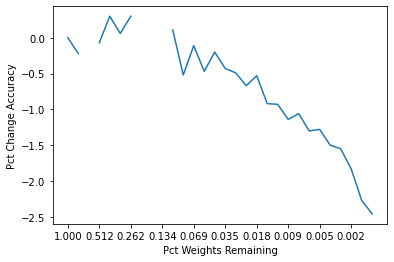

In [42]:
import matplotlib.pyplot as plt
avg_test = np.mean(test_acc, axis=0)
d_test_acc = [(i-avg_test[0])*100 for i in avg_test]
plt.plot(d_test_acc)
plt.xticks(ticks=[i for i in range(0,30,3)], labels=["{:.3f}".format(0.8**i) for i in range(0,30,3)])
plt.xlabel("Pct Weights Remaining")
plt.ylabel("Pct Change Accuracy")
plt.show()

In [23]:
plt.savefig("gcn_prune_fig.png")

<Figure size 432x288 with 0 Axes>

In [21]:
%matplotlib inline

In [41]:
test_acc[test_acc > 10000] = 0